In [1]:
import json
import bz2
import regex
import pandas as pd
import numpy as np
import nltk
import matplotlib.pyplot as plt
import seaborn as sns
import re
# import pprint

from tqdm import tqdm
from scipy import sparse
# from collections import Counter

import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = 10, 8

from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

# from natasha import *
from natasha import LocationExtractor

%matplotlib inline
%pylab inline
%config InlineBackend.figure_format = 'retina'

Populating the interactive namespace from numpy and matplotlib


In [13]:
responses = []
with bz2.BZ2File('/Users/aleksandr/Downloads/nlp-netology-master/2/banki_responses.json.bz2', 'r') as thefile:
    for row in tqdm(thefile):
        resp = json.loads(row)
        if not resp['rating_not_checked'] and (len(resp['text'].split()) > 0):
            responses.append(resp)

201030it [01:45, 1912.94it/s]


#  Домашнее задание по NLP # 1 [100 баллов]
## Классификация по тональности 

В этом домашнем задании вам предстоит классифицировать по тональности отзывы на банки с сайта banki.ru. [Ссылка на данные](https://drive.google.com/open?id=1CPKtX5HcgGWRpzbWZ2fMCyqgHGgk21l2).

Данные содержат непосредственно тексты отзывов, некоторую дополнительную информацию, а также оценку по шкале от 1 до 5. 

Тексты хранятся в json-ах в массиве responses.

Посмотрим на пример отзыва:

In [14]:
responses[99]

{'city': 'г. Саратов',
 'rating_not_checked': False,
 'title': 'Карта ко вкладу',
 'num_comments': 0,
 'bank_license': 'лицензия № 880',
 'author': 'ronnichka',
 'bank_name': 'Югра',
 'datetime': '2015-06-03 20:56:57',
 'text': 'Здравствуйте! Хотела написать, что мне месяц не выдают карту ко вкладу, ссылаясь на "нам же их из Самары везут" (на секундочку 5 часов езды от нашего города). Но! Прочитала, что людям 3,5 месяцев не выдают карту, и поняла, что у меня все хорошо, пока что. И подарок мне дали, и кулер в отделении есть. Так что я, конечно, готова ждать. Правда хотелось бы не очень долго.',
 'rating_grade': 3}

## Часть 1. Анализ текстов [40/100]

1. Посчитайте количество отзывов в разных городах и на разные банки
2. Постройте гистограмы длин слов в символах и в словах (не обязательно)
3. Найдите 10 самых частых:
    * слов
    * слов без стоп-слов
    * лемм 
* существительных
4. Постройте кривую Ципфа
5. Ответьте на следующие вопросы:
    * какое слово встречается чаще, "сотрудник" или "клиент"?
    * сколько раз встречается слова "мошенничество" и "доверие"?
6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру $tf-idf$, для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [15]:
data = pd.DataFrame(responses)
data.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153499 entries, 0 to 153498
Data columns (total 10 columns):
author                153479 non-null object
bank_license          153498 non-null object
bank_name             153499 non-null object
city                  138325 non-null object
datetime              153499 non-null object
num_comments          153499 non-null int64
rating_grade          88658 non-null float64
rating_not_checked    153499 non-null bool
text                  153499 non-null object
title                 153499 non-null object
dtypes: bool(1), float64(1), int64(1), object(7)
memory usage: 10.7+ MB


### 1. Посчитайте количество отзывов в разных городах и на разные банки

In [17]:
# База городов России и не только

# https://habr.com/ru/post/21949/
# http://download.geonames.org/export/dump/
# https://github.com/Legostaev/contry_region_city/

ct = pd.read_csv('/Users/aleksandr/Desktop/rocid.csv (copy 3)/city.csv', sep=';', encoding='cp1251')
ct.head()

,city_id,country_id,region_id,name
0,4400,3159,4312,Москва
1,4313,3159,4312,Абрамцево
2,4314,3159,4312,Алабино
3,4315,3159,4312,Апрелевка
4,4316,3159,4312,Архангельское


In [18]:
X_df1, Y_df2 = data.city, ct.name

speech_recognition = X_df1.to_list()
claim_list = Y_df2.to_list()

In [19]:
import Levenshtein

def n_sort(x=claim_list, y=speech_recognition):
    
    l = Levenshtein.distance
    c = []
    
    for i in y:
        b = sorted({r: l(i, r) for r in x}.items(), key = lambda x: x[1])[0]
        c.append(
            ['Ввели: "{}" - Скорее всего имели ввиду: "{}" - Колличество min подборов: "{}"'.format(i, b[0], b[1])]
        ) 
   
    return c

In [20]:
n_sort(claim_list, speech_recognition[0:30])

[['Ввели: "г. Москва" - Скорее всего имели ввиду: "Москва" - Колличество min подборов: "3"'],
 ['Ввели: "г. Новосибирск" - Скорее всего имели ввиду: "Новосибирск" - Колличество min подборов: "3"'],
 ['Ввели: "г. Москва" - Скорее всего имели ввиду: "Москва" - Колличество min подборов: "3"'],
 ['Ввели: "г. Ставрополь" - Скорее всего имели ввиду: "Ставрополь" - Колличество min подборов: "3"'],
 ['Ввели: "г. Челябинск" - Скорее всего имели ввиду: "Челябинск" - Колличество min подборов: "3"'],
 ['Ввели: "г. Москва" - Скорее всего имели ввиду: "Москва" - Колличество min подборов: "3"'],
 ['Ввели: "г. Волгоград" - Скорее всего имели ввиду: "Волгоград" - Колличество min подборов: "3"'],
 ['Ввели: "г. Москва" - Скорее всего имели ввиду: "Москва" - Колличество min подборов: "3"'],
 ['Ввели: "г. Пермь" - Скорее всего имели ввиду: "Пермь" - Колличество min подборов: "3"'],
 ['Ввели: "г. Ростов-на-Дону" - Скорее всего имели ввиду: "Ростов-на-Дону" - Колличество min подборов: "3"'],
 ['Ввели: "г. Мо

**Левинштейн хорошо справился с тем что и так неплохо, а вот с более сложными вещами подвел...**\
_'Ввели: "г. Фролово (Волгоградская обл.)" - Скорее всего имели ввиду: "Сургут (Самарская обл.)" - Колличество min подборов: "17"'_

Далее:
- Попробую применить Наташу.

Также видно, что все портят записи в скобках возможно стоит избавиться от них, если Наташа даст результат хуже Ливенштейна\
В крайнем случае буду урезать датасет, т.к. пожертвовать выбросами куда лучше, чем продолжать с ними.

p.s. Датасет весьма неприятный, такого рода опечатки стоит править на стадии сбора данных...

In [21]:
# from natasha import *
from natasha import LocationExtractor

def extract_city(text):
    if isinstance(text, str):
        extractor = LocationExtractor()
        matches = extractor(text)
        if len(matches) > 0:
            return matches[0].fact.name
        else:
            return None
    else:
        return None

In [22]:
cities = pd.DataFrame(data.city.unique(), columns=['orig_name'])
cities['clean_name'] = cities['orig_name'].apply(extract_city)

In [23]:
cities.head()

,orig_name,clean_name
0,г. Москва,москва
1,г. Новосибирск,новосибирск
2,г. Ставрополь,ставрополь
3,г. Челябинск,челябинск
4,г. Волгоград,волгоград


In [24]:
on = cities.orig_name.value_counts().sum()
cn = cities.clean_name.value_counts().sum()

print('\n{0}'.format(int(on-cn)))


1050


**Уже лучше, потеря 1050 выбросов не так плохо.**

Добавляем в основной Data Set

In [25]:
data['clean_city'] = data['city'].replace(cities['orig_name'].tolist(), cities['clean_name'].str.title().tolist())

In [26]:
data.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,Москва
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,Новосибирск
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,Москва


Посмотрев более подробно на данные у столбца 'city' присутствуют значения None и как следствие у 'clean_city' тоже, чтобы почистить ds от аномалий отсортируем его по этому признаку.

In [27]:
df_base = data.copy() # копия
df_isna = data[pd.isna(data.clean_city)] # тут NaN по городам

# данные по городам без пропусков, в рамках данной работы буду брать наиболее очищенные данные пусть и в убыток количеству
df_notna = data[pd.notna(data.clean_city)]

In [40]:
# df_base.city.value_counts(dropna=False)

In [28]:
df_notna.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 135080 entries, 0 to 138946
Data columns (total 11 columns):
author                135079 non-null object
bank_license          135079 non-null object
bank_name             135080 non-null object
city                  135080 non-null object
datetime              135080 non-null object
num_comments          135080 non-null int64
rating_grade          73151 non-null float64
rating_not_checked    135080 non-null bool
text                  135080 non-null object
title                 135080 non-null object
clean_city            135080 non-null object
dtypes: bool(1), float64(1), int64(1), object(8)
memory usage: 11.5+ MB


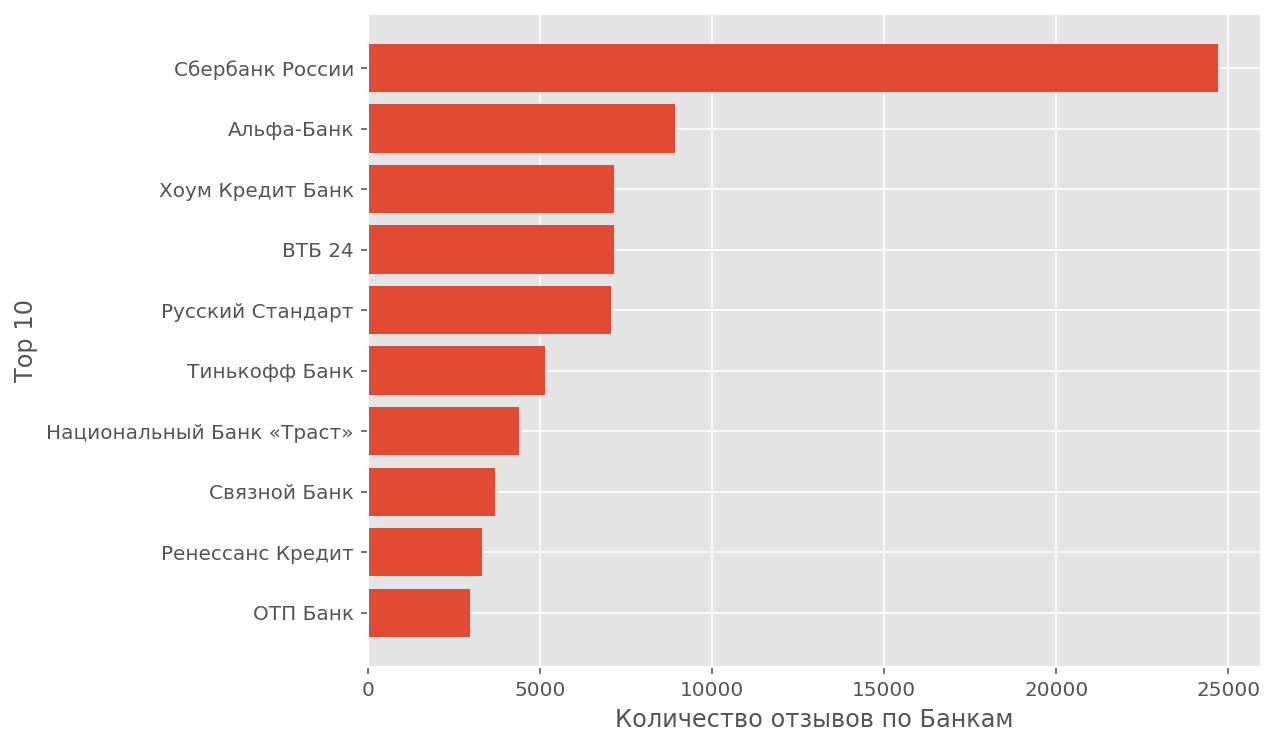

In [29]:
banks = df_notna.groupby(['bank_name']).count()['text'].sort_values(ascending=False).head(10)
rcParams['figure.figsize'] = 8, 6
plt.barh(banks.index[::-1],banks.values[::-1])
plt.xlabel('Количество отзывов по Банкам')
plt.ylabel('Top 10')
plt.show()

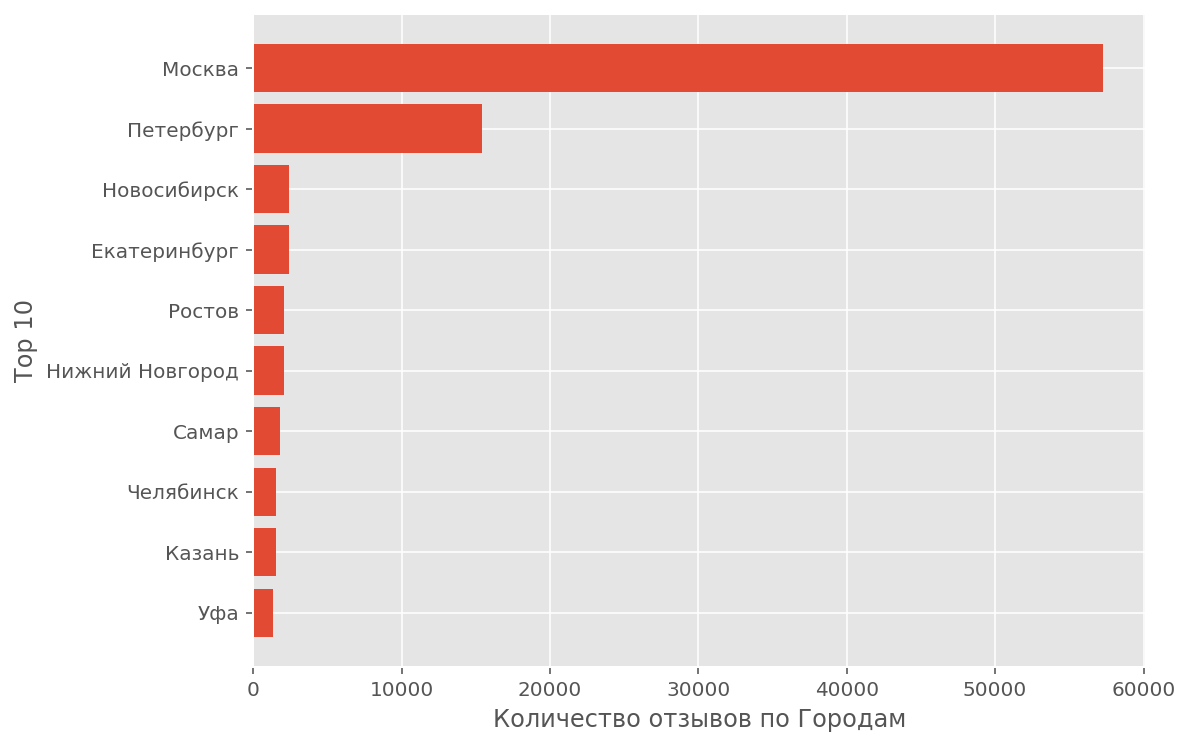

In [30]:
cities = df_notna.groupby(['clean_city']).count()['text'].sort_values(ascending=False).head(10)
rcParams['figure.figsize'] = 8, 6
plt.barh(cities.index[::-1],cities.values[::-1])
plt.xlabel('Количество отзывов по Городам')
plt.ylabel('Top 10')
plt.show()

Стоит заметить, что город Москву и Питер стоит считать как аномалию в данных, столицу я бы рассматривал отдельно от всех остальных городов. Также в ds присутствует Time series что добавляет в данные мульти сезонность... опустим в этой работе но я бы брал данные только за крайние 2-3 года. Возможные фичи: год, месяц, день недели, время.

### 2. Постройте гистограмы длин слов в символах и в словах (не обязательно)

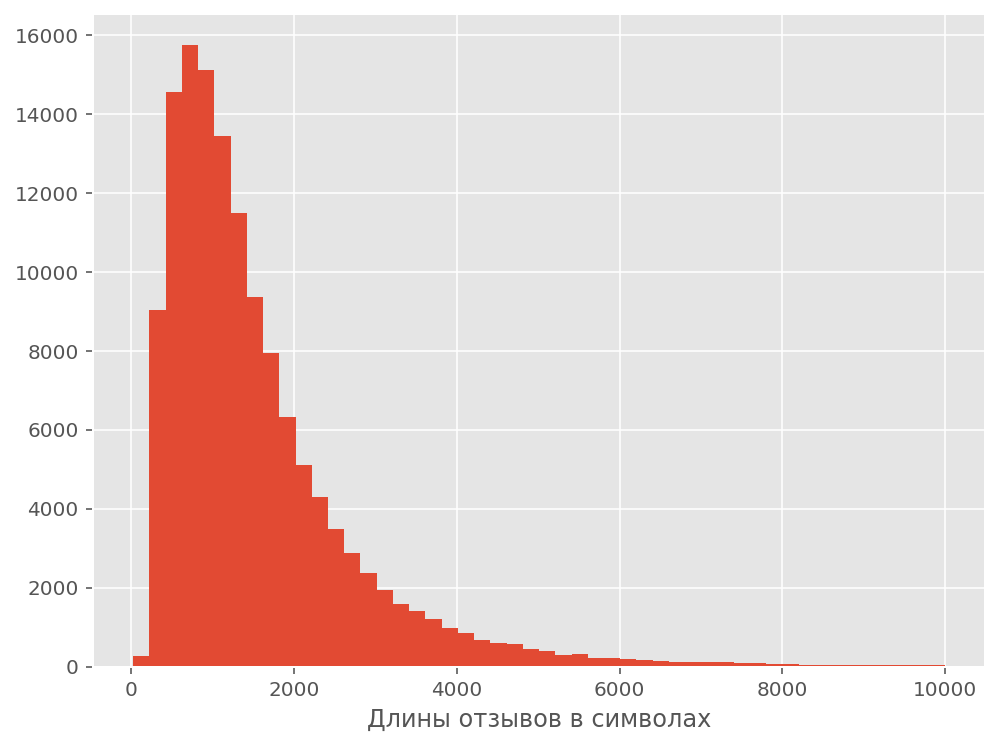

In [31]:
len_c = df_notna.text.apply(len)
rcParams['figure.figsize'] = 8, 6
len_c[len_c<10000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в символах')
plt.ylabel('')
plt.show()

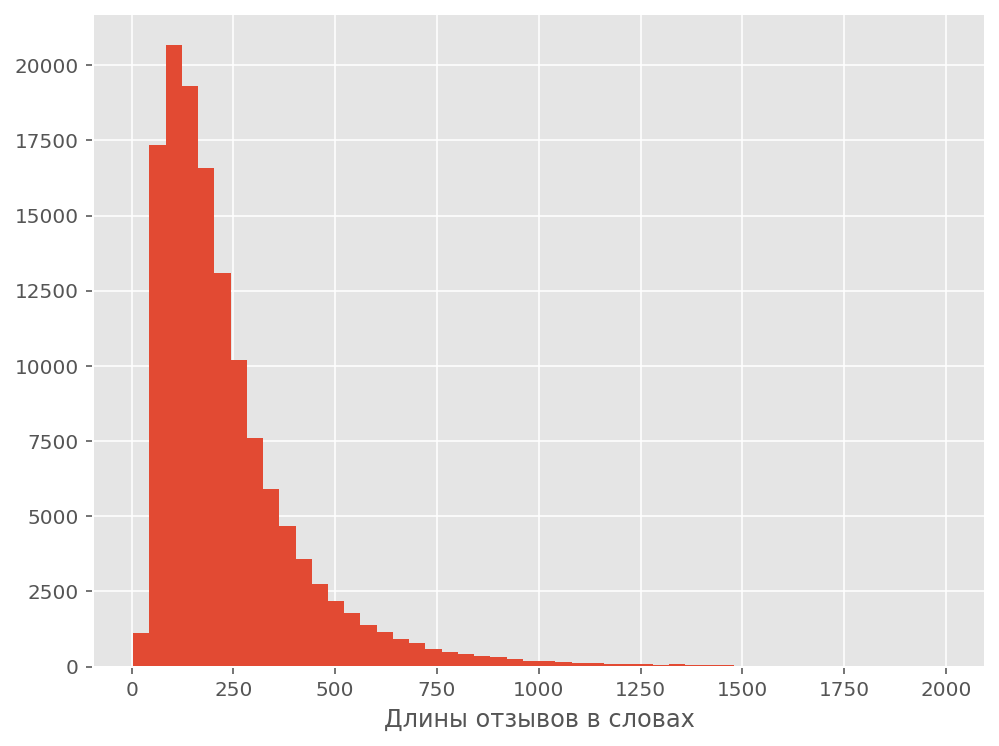

In [32]:
len_t = df_notna.text.str.split().apply(len)
rcParams['figure.figsize'] = 8, 6
len_t[len_t<2000].plot(kind='hist',bins=50)
plt.xlabel('Длины отзывов в словах')
plt.ylabel('')
plt.show()

### 3. Найдите 10 самых частых:
- слов
- слов без стоп-слов
- лемм
- существительных

#### Слова

In [34]:
regex = re.compile("[А-Яа-я]+")

def words_only(text, regex=regex):
    try:
        return " ".join(regex.findall(text))
    except:
        return ""

In [35]:
df = df_notna.copy()
df['text_tokinized'] =  df.text.str.lower().apply(words_only)

In [37]:
from tqdm import tqdm_notebook as tqdm
from collections import Counter

cnt = Counter()
n_types = []
n_tokens = []
tokens = []

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(list(cnt.values())))

for i in cnt.most_common(10):
    print(i)


('в', 1184949)
('и', 941477)
('не', 763476)
('на', 630821)
('что', 571135)
('я', 517705)
('с', 415119)
('по', 335326)
('мне', 288927)
('банка', 250482)


#### Cлова без стоп-слов

In [38]:
from nltk.corpus import stopwords
# import nltk
# nltk.download('stopwords')

mystopwords = stopwords.words('russian') + ['это', 'наш' , 'тыс', 'млн', 'млрд', 'также', 'т', 'д', 'г']
def remove_stopwords(text, mystopwords=mystopwords):
    try:
        return " ".join([token for token in text.split() if not token in mystopwords])
    except:
        return ""

In [39]:
df['text_tokinized_stop_worlds'] = df.text_tokinized.str.lower().apply(remove_stopwords)

In [40]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,Москва,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,Новосибирск,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,Москва,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...


In [41]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['text_tokinized_stop_worlds'].split()
    tokens_all+=tokens
    cnt.update(tokens)
    n_types.append(len(cnt))
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)


('банка', 250482)
('банк', 194099)
('деньги', 117318)
('карту', 95830)
('карты', 93528)
('кредит', 70968)
('день', 68913)
('заявление', 64535)
('банке', 64044)
('отделение', 59582)


('г', 61082) - неожиданно. считалось 30+ минут\
Далее сделал пересчет с + 'г' в стоп словах

банка, банк, банке - Леммы должны улучшить данные

#### Леммы

In [42]:
from pymorphy2 import MorphAnalyzer
from pymystem3 import Mystem

In [43]:
m = Mystem()

def lemmatize(text, mystem=m):
    try:
        return "".join(m.lemmatize(text)).strip()  
    except:
        return " "

In [44]:
mystoplemmas = stopwords.words('russian') + ['который','прошлый','сей', 'свой', 'наш', 'мочь', 'г']

def remove_stoplemmas(text, mystoplemmas=mystoplemmas):
    try:
        return " ".join([token for token in text.split() if not token in mystoplemmas])
    except:
        return ""

In [45]:
df['lemma'] = df['text_tokinized_stop_worlds'].apply(lemmatize)

In [46]:
df.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma
0,uhnov1,лицензия № 2562,Бинбанк,г. Москва,2015-06-08 12:50:54,0,NaN,False,Добрый день! Я не являюсь клиентом банка и пор...,Жалоба,Москва,добрый день я не являюсь клиентом банка и пору...,добрый день являюсь клиентом банка поручителем...,добрый день являться клиент банк поручитель кр...
1,Foryou,лицензия № 1481,Сбербанк России,г. Новосибирск,2015-06-08 11:09:57,0,NaN,False,Доброго дня! Являюсь держателем зарплатной кар...,Не могу пользоваться услугой Сбербанк он-лайн,Новосибирск,доброго дня являюсь держателем зарплатной карт...,доброго дня являюсь держателем зарплатной карт...,добрый день являться держатель зарплатной карт...
2,Vladimir84,лицензия № 2562,Бинбанк,г. Москва,2015-06-05 20:14:28,1,NaN,False,Здравствуйте! Дублирую свое заявление от 03.0...,Двойное списание за один товар.,Москва,здравствуйте дублирую свое заявление от в до м...,здравствуйте дублирую свое заявление можайский...,здравствовать дублировать свой заявление можай...


In [47]:
cnt = Counter()
n_types = []
n_tokens = []
tokens = []
tokens_all=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['lemma'].split()
    cnt.update(tokens)
    n_types.append(len(cnt))
    tokens_all+=tokens
    n_tokens.append(sum(cnt.values()))
    
for i in cnt.most_common(10):
    print(i)


('банк', 560845)
('карта', 304772)
('деньги', 160389)
('день', 155099)
('мой', 148714)
('кредит', 137617)
('который', 134031)
('отделение', 127724)
('сотрудник', 122619)
('клиент', 121659)


#### Существительные

In [48]:
def to_nouns(text, mystem=m):
    m=MorphAnalyzer()
    try:
        return " ".join([noun for noun in text.split() if m.parse(noun)[0].tag.POS =='NOUN'])
    except:
        return []

to_nouns(df.lemma.iloc[1])

'день держатель карта сбербанк россия год фамилия банк документ копия паспорт свидетельство брак карта фамилия муж токарева мария александровна секлетина необходимость услуга сбербанк страница карта специалист отделение сбербанк база банк фамилия секлетина скан документ контакт звонок ч время ситуация база секлетина карта фамилия токарева связь истечение срок обслуживание документ копия паспорт свидетельство брак результат ноль ситуация уважение токарев мария александровна'

In [49]:
from multiprocessing import Pool

with Pool() as p:
    df['nouns']=p.map(to_nouns,df.lemma)

In [50]:
cnt_noun = Counter()
n_types_noun = []
n_tokens_noun= []
tokens_noun = []
tokens_all_noun=[]

for index, row in tqdm(df.iterrows(), total = len(df)):
    tokens = row['nouns'].split()
    cnt_noun.update(tokens)
    n_types_noun.append(len(cnt))
    tokens_all_noun+=tokens
    n_tokens_noun.append(sum(cnt.values()))

for i in cnt_noun.most_common(10):
    print(i)


('банк', 560845)
('карта', 304772)
('деньги', 160389)
('день', 155099)
('кредит', 137617)
('отделение', 127724)
('сотрудник', 122619)
('клиент', 121659)
('счет', 112766)
('сумма', 100614)


### 4. Постройте кривую Ципфа

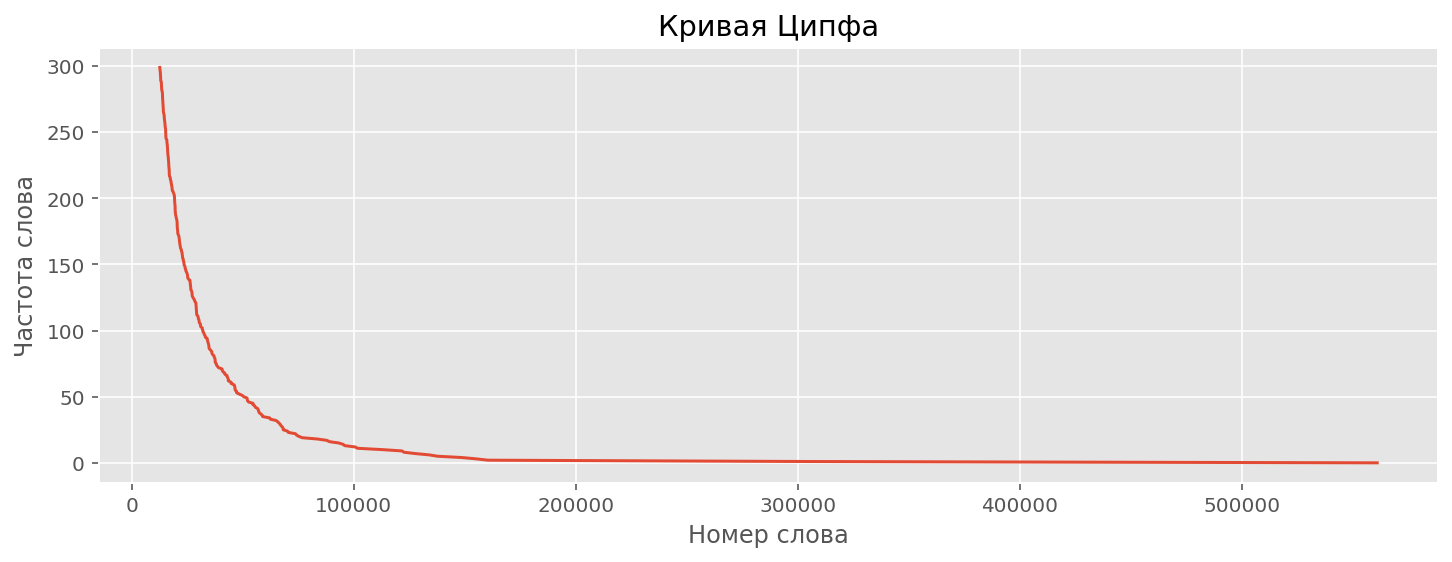

In [51]:
freqs = list(cnt.values())
freqs = sorted(freqs, reverse = True)

fig, ax = plt.subplots(figsize=(12,4))
ax.plot(freqs[:300], range(300))
plt.xlabel('Номер слова')
plt.ylabel('Частота слова')
plt.title('Кривая Ципфа')
plt.show()

In [53]:
# fig, ax = plt.subplots(figsize=(12,4))
# ax.plot(n_tokens,n_types)
# plt.xlabel('Количество  токенов')
# plt.ylabel('Число слов')
# plt.title('Кривая Хипса')
# plt.show()

### 5. Ответьте на следующие вопросы:
- какое слово встречается чаще, "сотрудник" или "клиент"?
- сколько раз встречается слова "мошенничество" и "доверие"?

In [54]:
from nltk import FreqDist
Freq_Dist = FreqDist(tokens_all)

In [57]:
print('Слово "сотрудник" встречается -"',Freq_Dist['сотрудник'],'раз')
print('Слово "клиент" встречается -"',Freq_Dist['клиент'],'раз')

Слово "сотрудник" встречается -" 122619 раз
Слово "клиент" встречается -" 121659 раз


Слов "клиент" > Слов "сотрудник"

In [58]:
print('Слово "мошенничество" встречается -"',Freq_Dist['мошенничество'],'раз')
print('Слово "доверие" встречается -"',Freq_Dist['доверие'],'раз')

Слово "мошенничество" встречается -" 3046 раз
Слово "доверие" встречается -" 1884 раз


Слов "мошенничество" > Слов "доверие"

### 6. В поле "rating_grade" записана оценка отзыва по шкале от 1 до 5. Используйте меру 𝑡𝑓−𝑖𝑑𝑓 , для того, чтобы найти ключевые слова и биграмы для положительных отзывов (с оценкой 5) и отрицательных отзывов (с оценкой 1)

In [64]:
df['rating_grade'].value_counts()

1.0    39026
2.0    12995
5.0    10273
3.0     7362
4.0     3495
Name: rating_grade, dtype: int64

Сбалансируем выборки

In [65]:
num=10000

df_sample = df[(df.rating_grade==1)].sample(n=num).copy()
df_sample = df_sample.append(df[(df.rating_grade==5)].sample(n=num))

df_sample.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [66]:
tokens_by_topic = []

for rating in df_sample.rating_grade.unique():
    tokens=[]
    sample=df_sample[df_sample['rating_grade']==rating]
    
    for i in range(len(sample)):
        tokens += sample.lemma.iloc[i].split()
        
    tokens_by_topic.append(tokens)

In [68]:
df_sample.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma,nouns
119921,andrey_egorov,лицензия № 3292,Райффайзенбанк,г. Санкт-Петербург,2011-09-02 15:42:00,6,1.0,False,Прошу отдел качества максимально внимательно о...,"""Мы заблокировали, но почему - не знаем!""",Петербург,прошу отдел качества максимально внимательно о...,прошу отдел качества максимально внимательно о...,просить отдел качество максимально внимательно...,отдел качество обращение обращение банк август...
89328,*Galina*,лицензия № 1623,ВТБ 24,г. Новосибирск,2013-03-04 09:21:00,1,1.0,False,Подала заявку на получение потребительского кр...,Отвратительное обслуживание,Новосибирск,подала заявку на получение потребительского кр...,подала заявку получение потребительского креди...,подавать заявка получение потребительский кред...,заявка получение кредит интернет москва анкета...
48436,Не клиентkzn,лицензия № 3279,Национальный Банк «Траст»,г. Казань,2014-05-05 19:21:00,2,1.0,False,Согласна со всеми раннее оставленными отзывами...,Звонки из банка,Казань,согласна со всеми раннее оставленными отзывами...,согласна всеми раннее оставленными отзывами не...,согласный все ранний оставлять отзыв некомпете...,согласный отзыв работа сотрудник центр дирекци...


#### Униграммы

In [69]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(1,1), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_5 = []
tfidf_ranking_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_1.append(phrase)

In [70]:
rank = pd.DataFrame({'tfidf_ranking_5': tfidf_ranking_5,'tfidf_ranking_1': tfidf_ranking_1})
rank.head(10)

,tfidf_ranking_5,tfidf_ranking_1
0,банк,банк
1,карта,карта
2,очень,деньги
3,клиент,день
4,день,мой
5,сотрудник,отделение
6,кредит,сотрудник
7,который,который
8,отделение,кредит
9,вклад,счет


Убираем пересечения

In [73]:
rank['tfidf_ranking_5_without_1']=rank.tfidf_ranking_5[~rank.tfidf_ranking_5.isin(rank.tfidf_ranking_1)]
rank['tfidf_ranking_1_without_5']=rank.tfidf_ranking_1[~rank.tfidf_ranking_1.isin(rank.tfidf_ranking_5)]

In [78]:
rank.iloc[:,-2:].dropna()

,tfidf_ranking_5_without_1,tfidf_ranking_1_without_5
20,обслуживание,ответ
30,быстро,номер
32,интернет,написать
36,банка,ваш
38,очередь,средство
39,открывать,отвечать
45,хороший,звонок
59,самый,операция
63,помогать,давать
67,вс,знать


#### Биграммы

In [79]:
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

tfidf = TfidfVectorizer(analyzer='word', ngram_range=(2,2), min_df = 0)
tfidf_matrix =  tfidf.fit_transform([' '.join(tokens) for tokens in tokens_by_topic])
feature_names = tfidf.get_feature_names() 
tfidf_ranking_rank_is_5 = []
tfidf_ranking_rank_is_1 = []
dense = tfidf_matrix.todense()

text = dense[1].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_5.append(phrase)
    
text = dense[0].tolist()[0]
phrase_scores = [pair for pair in zip(range(0, len(text)), text) if pair[1] > 0]
sorted_phrase_scores = sorted(phrase_scores, key=lambda t: t[1] * -1)
phrases = []

for phrase, score in [(feature_names[word_id], score) for (word_id, score) in sorted_phrase_scores][:70]:
    tfidf_ranking_rank_is_1.append(phrase) 

In [81]:
rankings = pd.DataFrame({'tfidf_ranking_rank_is_5': tfidf_ranking_rank_is_5,'tfidf_ranking_rank_is_1': tfidf_ranking_rank_is_1})
rankings.head(10)

,tfidf_ranking_rank_is_5,tfidf_ranking_rank_is_1
0,интернет банк,сотрудник банк
1,другой банк,денежный средство
2,сотрудник банк,отделение банк
3,кредитный карта,кредитный карта
4,клиент банк,написать заявление
5,открывать вклад,горячий линия
6,отделение банк,колл центр
7,являться клиент,рабочий день
8,следующий день,интернет банк
9,добрый день,служба поддержка


In [82]:
rankings['tfidf_ranking_rank_is_5_without_1']=rankings.tfidf_ranking_rank_is_5[~rankings.tfidf_ranking_rank_is_5.isin(rankings.tfidf_ranking_rank_is_1)]
rankings['tfidf_ranking_rank_is_1_without_5']=rankings.tfidf_ranking_rank_is_1[~rankings.tfidf_ranking_rank_is_1.isin(rankings.tfidf_ranking_rank_is_5)]

In [83]:
rankings.iloc[:,-2:].dropna()

,tfidf_ranking_rank_is_5_without_1,tfidf_ranking_rank_is_1_without_5
13,выражать благодарность,сей пора
19,приятно удивлять,получать ответ
22,банк очень,писать заявление
24,год назад,течение день
25,очень довольный,номер телефон
26,мой вопрос,обращаться отделение
30,большой спасибо,мой заявление
34,огромный спасибо,мой деньги
36,услуга банк,снимать деньги
37,банк москва,погашение кредит


## Часть 2. Тематическое моделирование [20/100]

1. Постройте несколько тематических моделей коллекции документов с разным числом тем. Приведите примеры понятных (интерпретируемых) тем.
2. Найдите темы, в которых упомянуты конкретные банки (Сбербанк, ВТБ, другой банк). Можете ли вы их прокомментировать / объяснить?

Эта часть задания может быть сделана с использованием gensim. 

In [86]:
import gensim.corpora as corpora
from gensim.models import ldamodel

In [87]:
texts = [df['lemma'].iloc[i].split() for i in range(len(df))]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]

In [88]:
random.seed(11)

In [89]:
lda = ldamodel.LdaModel(corpus=corpus, 
                        id2word=dictionary, 
                        num_topics=20, 
                        alpha='auto', 
                        eta='auto', 
                        iterations = 20, 
                        passes = 5)

In [90]:
# 20 тем, рандомная выборка 5
lda.show_topics(5)

[(15,
  '0.067*"рубль" + 0.052*"курс" + 0.046*"доллар" + 0.045*"валюта" + 0.045*"евро" + 0.038*"комиссия" + 0.037*"сумма" + 0.032*"кассир" + 0.020*"валютный" + 0.019*"касса"'),
 (5,
  '0.048*"лимит" + 0.030*"связной" + 0.030*"покупка" + 0.025*"магазин" + 0.023*"акция" + 0.022*"период" + 0.022*"кредитный" + 0.021*"ткс" + 0.017*"карта" + 0.017*"балл"'),
 (2,
  '0.042*"день" + 0.031*"банк" + 0.027*"позвонить" + 0.021*"звонить" + 0.018*"сказать" + 0.015*"телефон" + 0.014*"центр" + 0.014*"заявка" + 0.013*"звонок" + 0.013*"вопрос"'),
 (19,
  '0.016*"сказать" + 0.015*"говорить" + 0.015*"девушка" + 0.012*"приходить" + 0.012*"деньги" + 0.011*"вс" + 0.009*"знать" + 0.009*"спрашивать" + 0.008*"думать" + 0.008*"давать"'),
 (13,
  '0.060*"банк" + 0.022*"клиент" + 0.012*"который" + 0.010*"свой" + 0.009*"год" + 0.009*"такой" + 0.008*"другой" + 0.007*"проблема" + 0.007*"время" + 0.007*"один"')]

1. Обмен валют
2. Покупка по акции, что-то связанное баллами карты
3. Заявка в тех. поддержку банка
4. Консультации в банке
5. Проблема пастоянного клиента с банком

In [91]:
lda15 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=15, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [92]:
# 25 тем, рандомная выборка 5
lda15.show_topics(5)

[(8,
  '0.131*"вклад" + 0.039*"открывать" + 0.037*"банк" + 0.027*"депозит" + 0.026*"процент" + 0.020*"деньги" + 0.020*"договор" + 0.017*"офис" + 0.014*"сумма" + 0.014*"ставка"'),
 (9,
  '0.078*"кредит" + 0.023*"банк" + 0.017*"кредитный" + 0.017*"документ" + 0.015*"договор" + 0.015*"оформлять" + 0.015*"заявка" + 0.014*"страховка" + 0.011*"квартира" + 0.011*"сумма"'),
 (12,
  '0.019*"отделение" + 0.016*"очередь" + 0.013*"работать" + 0.012*"минута" + 0.010*"человек" + 0.010*"девушка" + 0.009*"офис" + 0.008*"касса" + 0.008*"час" + 0.008*"клиент"'),
 (4,
  '0.030*"день" + 0.029*"банк" + 0.020*"сказать" + 0.019*"позвонить" + 0.015*"звонить" + 0.014*"ответ" + 0.013*"вопрос" + 0.012*"отделение" + 0.011*"отвечать" + 0.010*"телефон"'),
 (10,
  '0.054*"банк" + 0.021*"клиент" + 0.016*"очень" + 0.009*"который" + 0.009*"свой" + 0.009*"работа" + 0.009*"время" + 0.009*"сотрудник" + 0.008*"вопрос" + 0.008*"год"')]

1. Открытие депозита
2. Кредит, страховка, что-то связанное с квартирой
3. Очередь в банке
4. Звонок в банке
5. Вопрос клиента сотруднику банка

In [93]:
lda10 = ldamodel.LdaModel(corpus=corpus, 
                          id2word=dictionary, 
                          num_topics=10, 
                          alpha='auto', 
                          eta='auto', 
                          iterations = 20, 
                          passes = 5)

In [100]:
# 10 тем
lda10.show_topics(5)

[(5,
  '0.051*"кредит" + 0.031*"документ" + 0.027*"банк" + 0.023*"заявка" + 0.016*"кредитный" + 0.013*"оформлять" + 0.012*"справка" + 0.012*"договор" + 0.010*"страховка" + 0.010*"менеджер"'),
 (0,
  '0.049*"вклад" + 0.043*"банк" + 0.026*"договор" + 0.021*"счет" + 0.015*"открывать" + 0.011*"условие" + 0.010*"процент" + 0.009*"документ" + 0.009*"клиент" + 0.008*"открытие"'),
 (2,
  '0.034*"деньги" + 0.030*"заявление" + 0.030*"банкомат" + 0.023*"сбербанк" + 0.021*"мой" + 0.018*"банк" + 0.018*"день" + 0.016*"карта" + 0.016*"претензия" + 0.015*"отделение"'),
 (4,
  '0.048*"банк" + 0.019*"клиент" + 0.014*"очень" + 0.009*"который" + 0.009*"свой" + 0.008*"работа" + 0.008*"год" + 0.007*"время" + 0.007*"вопрос" + 0.007*"сотрудник"'),
 (6,
  '0.020*"сказать" + 0.017*"день" + 0.015*"банк" + 0.012*"звонить" + 0.012*"позвонить" + 0.012*"говорить" + 0.010*"деньги" + 0.010*"мочь" + 0.009*"отвечать" + 0.009*"приходить"')]

1. Заявка на кредитный догово
2. Открытие вклада
3. Претензия клиента банку сбербанка
4. Вопрос в поддержку банка
5. Звонок клиента в банк

## Часть 3. Классификация текстов [40/100]

Сформулируем для простоты задачу бинарной классификации: будем классифицировать на два класса, то есть, различать резко отрицательные отзывы (с оценкой 1) и положительные отзывы (с оценкой 5). 

1.  Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте ```sklearn.model_selection.train_test_split``` для разделения множества отобранных документов на обучающее и тестовое. 
2. Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных $n$-грам. 
3. Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
    * 1-ый вариант: $tf-idf$ преобразование (```sklearn.feature_extraction.text.TfidfTransformer```) и сингулярное разложение (оно же – латентый семантический анализ) (```sklearn.decomposition.TruncatedSVD```), 
    * 2-ой вариант: тематические модели LDA (```sklearn.decomposition.LatentDirichletAllocation```). 


Используйте accuracy и F-measure для оценки качества классификации. 

Ниже написан примерный Pipeline для классификации текстов. 

Эта часть задания может быть сделана с использованием sklearn. 

#### Составьте обучающее и тестовое множество: выберите из всего набора данных N1 отзывов с оценкой 1 и N2 отзывов с оценкой 5 (значение N1 и N2 – на ваше усмотрение). Используйте sklearn.model_selection.train_test_split для разделения множества отобранных документов на обучающее и тестовое.

In [2]:
# df_sample.to_csv('sample.csv', index=False)
df_sample1 = pd.read_csv('/Users/aleksandr/Downloads/nlp-netology-master/sample.csv')
df_sample1.head(3)

,author,bank_license,bank_name,city,datetime,num_comments,rating_grade,rating_not_checked,text,title,clean_city,text_tokinized,text_tokinized_stop_worlds,lemma,nouns
0,andrey_egorov,лицензия № 3292,Райффайзенбанк,г. Санкт-Петербург,2011-09-02 15:42:00,6,1.0,False,Прошу отдел качества максимально внимательно о...,"""Мы заблокировали, но почему - не знаем!""",Петербург,прошу отдел качества максимально внимательно о...,прошу отдел качества максимально внимательно о...,просить отдел качество максимально внимательно...,отдел качество обращение обращение банк август...
1,*Galina*,лицензия № 1623,ВТБ 24,г. Новосибирск,2013-03-04 09:21:00,1,1.0,False,Подала заявку на получение потребительского кр...,Отвратительное обслуживание,Новосибирск,подала заявку на получение потребительского кр...,подала заявку получение потребительского креди...,подавать заявка получение потребительский кред...,заявка получение кредит интернет москва анкета...
2,Не клиентkzn,лицензия № 3279,Национальный Банк «Траст»,г. Казань,2014-05-05 19:21:00,2,1.0,False,Согласна со всеми раннее оставленными отзывами...,Звонки из банка,Казань,согласна со всеми раннее оставленными отзывами...,согласна всеми раннее оставленными отзывами не...,согласный все ранний оставлять отзыв некомпете...,согласный отзыв работа сотрудник центр дирекци...


In [3]:
df_sample1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20000 entries, 0 to 19999
Data columns (total 15 columns):
author                        20000 non-null object
bank_license                  20000 non-null object
bank_name                     20000 non-null object
city                          20000 non-null object
datetime                      20000 non-null object
num_comments                  20000 non-null int64
rating_grade                  20000 non-null float64
rating_not_checked            20000 non-null bool
text                          20000 non-null object
title                         19854 non-null object
clean_city                    20000 non-null object
text_tokinized                20000 non-null object
text_tokinized_stop_worlds    20000 non-null object
lemma                         20000 non-null object
nouns                         20000 non-null object
dtypes: bool(1), float64(1), int64(1), object(12)
memory usage: 2.2+ MB


In [4]:
df_sample1.rating_grade.value_counts()

5.0    10000
1.0    10000
Name: rating_grade, dtype: int64

In [5]:
df_sample1.columns

Index(['author', 'bank_license', 'bank_name', 'city', 'datetime',
       'num_comments', 'rating_grade', 'rating_not_checked', 'text', 'title',
       'clean_city', 'text_tokinized', 'text_tokinized_stop_worlds', 'lemma',
       'nouns'],
      dtype='object')

In [99]:
X = df_sample1['lemma'].values
y = df_sample1.rating_grade.values

In [100]:
X.shape, y.shape

((20000,), (20000,))

In [6]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.feature_extraction import DictVectorizer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, classification_report, confusion_matrix

In [101]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [102]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((14000,), (6000,), (14000,), (6000,))

In [78]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

#### Используйте любой известный вам алгоритм классификации текстов для решения задачи и получите baseline. Сравните разные варианты векторизации текста: использование только униграм, пар или троек слов или с использованием символьных  𝑛 -грам. (Ниже написан примерный Pipeline для классификации текстов).

In [1]:
# from sklearn.pipeline import Pipeline
# from sklearn.ensemble import RandomForestClassifier

# !!! На каждом этапе Pipeline нужно указать свои параметры
# 1-ый вариант: tf-idf + LSI
# 2-ой вариант: LDA

# clf = Pipeline([
#     ('vect', CountVectorizer(analyzer = 'char', ngram_range={4,6})),
#     ('clf', RandomForestClassifier()),
# ])

# clf = Pipeline([ 
#     ('vect', CountVectorizer()), 
#     ('tfidf', TfidfTransformer()), 
#     ('tm', TruncatedSVD()), 
#     ('clf', RandomForestClassifier())
# ])

In [103]:
clf_countvectorized = Pipeline(
    [('vect', CountVectorizer()),
     ('clf', LogisticRegression())]
)

params_cntv = {
    'vect__analyzer': ['word','char'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': ((1, 1), (2, 2), (3, 3)),
    'clf__C': np.logspace(-3,3,7),
    'clf__penalty': ['l1','l2']  
}

scores=['accuracy', 'f1']

In [106]:
grid_cntv = GridSearchCV(
    clf_countvectorized, 
    param_grid=params_cntv, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [107]:
grid_cntv.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  3.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 13.9min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 34.1min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 66.3min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [115]:
# print(grid_cntv.best_estimator_)
print("Best score: %0.3f" % grid_cntv.best_score_)

Best score: 0.950


In [110]:
predictions=grid_cntv.best_estimator_.predict(X_test)

In [160]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.95
Recall:      0.95
F1_score:    0.95
Accuracy:    0.95


In [112]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.95      0.95      2946
         5.0       0.96      0.94      0.95      3054

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



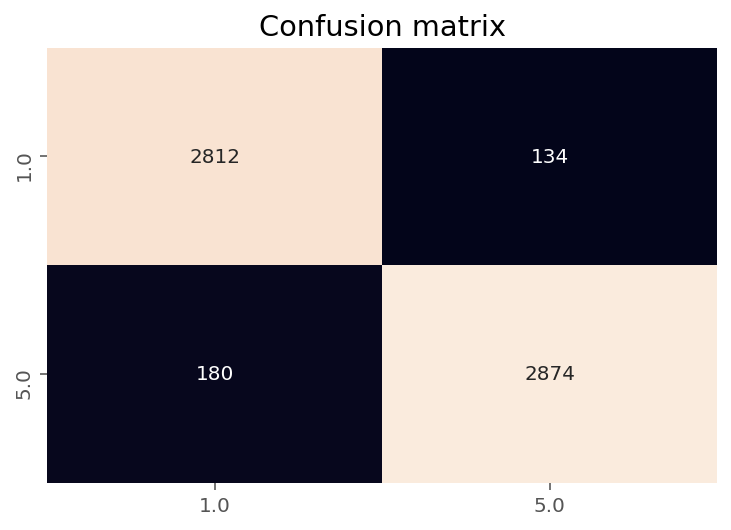

In [113]:
labels = grid_cntv.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

#### Сравните, как изменяется качество решения задачи при использовании скрытых тем в качестве признаков:
- 1-ый вариант:  𝑡𝑓−𝑖𝑑𝑓  преобразование (sklearn.feature_extraction.text.TfidfTransformer) и сингулярное разложение (оно же – латентый семантический анализ) (sklearn.decomposition.TruncatedSVD),
- 2-ой вариант: тематические модели LDA (sklearn.decomposition.LatentDirichletAllocation).

Используйте accuracy и F-measure для оценки качества классификации. (Эта часть задания может быть сделана с использованием sklearn).

#### 1-ый вариант

𝑡𝑓−𝑖𝑑𝑓

In [117]:
clf_tf_idf = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression())]
)

params_tf_idf={
    'vect__analyzer': ['word'],
    'vect__max_df': (0.5, 0.75, 1.0),
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tfidf__use_idf': (True, False),
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [118]:
grid_tf_idf = GridSearchCV(
    clf_tf_idf, 
    param_grid=params_tf_idf, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [119]:
grid_tf_idf.fit(X_train, y_train)

Fitting 3 folds for each of 252 candidates, totalling 756 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  2.4min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed:  9.7min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 22.3min
[Parallel(n_jobs=-1)]: Done 756 out of 756 | elapsed: 42.6min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [156]:
# print(grid_tf_idf.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf.best_score_)

Best score: 0.953


In [158]:
predictions=grid_tf_idf.best_estimator_.predict(X_test)

In [159]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.95
Recall:      0.95
F1_score:    0.95
Accuracy:    0.95


In [123]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.94      0.97      0.95      2946
         5.0       0.97      0.94      0.95      3054

    accuracy                           0.95      6000
   macro avg       0.95      0.95      0.95      6000
weighted avg       0.95      0.95      0.95      6000



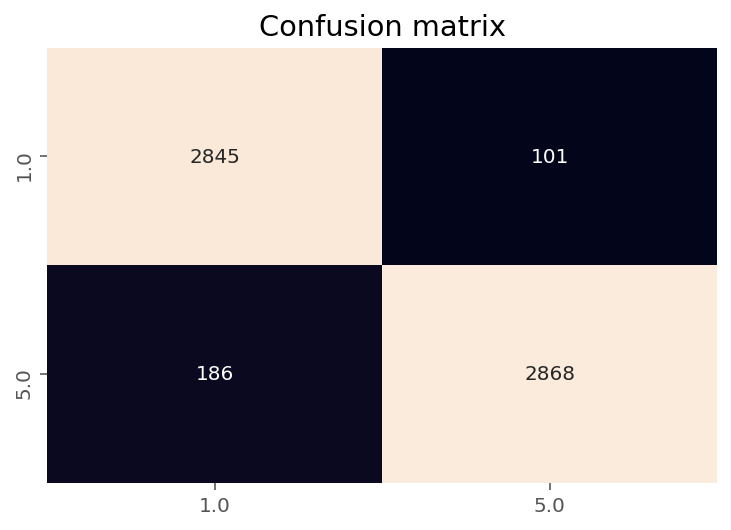

In [124]:
labels = grid_tf_idf.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

Cингулярное разложение

In [125]:
clf_tf_idf_TruncatedSVD = Pipeline(
    [('vect', CountVectorizer()),
     ('tfidf', TfidfTransformer()),
     ('tsvd', TruncatedSVD()),
     ('clf', LogisticRegression())]
)

params_tf_idf_TruncatedSVD={
    'vect__analyzer': ['word'],
    'vect__ngram_range': [(1, 1), (2, 2), (3, 3)],
    'tsvd__n_components': [5, 10, 25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1', 'l2']
}

scores=['accuracy','f1']

In [126]:
grid_tf_idf_TruncatedSVD = GridSearchCV(
    clf_tf_idf_TruncatedSVD, 
    param_grid=params_tf_idf_TruncatedSVD, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [127]:
grid_tf_idf_TruncatedSVD.fit(X_train, y_train)

Fitting 3 folds for each of 210 candidates, totalling 630 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:  8.3min
[Parallel(n_jobs=-1)]: Done 192 tasks      | elapsed: 85.1min
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed: 139.3min
[Parallel(n_jobs=-1)]: Done 630 out of 630 | elapsed: 183.7min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [161]:
# print(grid_tf_idf_TruncatedSVD.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_TruncatedSVD.best_score_)

Best score: 0.942


In [162]:
predictions=grid_tf_idf_TruncatedSVD.best_estimator_.predict(X_test)

In [163]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.94
Recall:      0.94
F1_score:    0.94
Accuracy:    0.94


In [131]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.93      0.95      0.94      2946
         5.0       0.95      0.93      0.94      3054

    accuracy                           0.94      6000
   macro avg       0.94      0.94      0.94      6000
weighted avg       0.94      0.94      0.94      6000



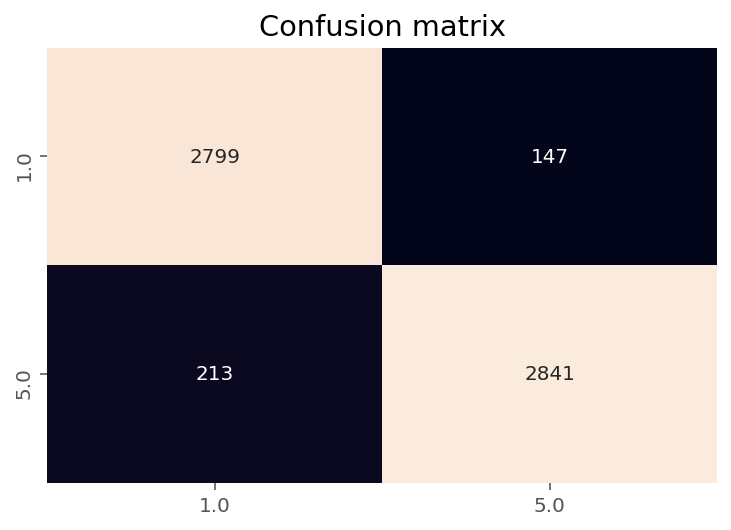

In [132]:
labels = grid_tf_idf_TruncatedSVD.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False, 
    xticklabels=labels, 
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

#### 2-ой вариант

LDA

In [136]:
clf_tf_idf_LDA = Pipeline(
    [('vect', CountVectorizer()),
     ('lda', LatentDirichletAllocation()),
     ('clf', LogisticRegression())]
)

params_tf_idf_LDA={
    'vect__analyzer': ['word'],
    'vect__max_df': [0.75],
    'vect__ngram_range': [(1, 1)],
    'lda__n_components' : [25, 50, 100],
    'clf__C': np.logspace(-3, 3, 7),
    'clf__penalty': ['l1']
}

scores=['accuracy', 'f1']

In [138]:
grid_tf_idf_LDA = GridSearchCV(
    clf_tf_idf_LDA, 
    param_grid=params_tf_idf_LDA, 
    cv=3,
    scoring=scores,
    refit=scores[0],
    n_jobs=-1, 
    verbose=1
)

In [139]:
grid_tf_idf_LDA.fit(X_train, y_train)

Fitting 3 folds for each of 21 candidates, totalling 63 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed: 38.1min
[Parallel(n_jobs=-1)]: Done  63 out of  63 | elapsed: 55.4min finished


GridSearchCV(cv=3, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('vect',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                            

In [140]:
# print(grid_tf_idf_LDA.best_estimator_)
print("Best score: %0.3f" % grid_tf_idf_LDA.best_score_)

Best score: 0.912


In [164]:
predictions=grid_tf_idf_LDA.best_estimator_.predict(X_test)

In [165]:
print("Precision: {0:6.2f}".format(precision_score(y_test, predictions, average='macro')))
print("Recall:    {0:6.2f}".format(recall_score(y_test, predictions, average='macro')))
print("F1_score:  {0:6.2f}".format(f1_score(y_test, predictions, average='macro')))
print("Accuracy:  {0:6.2f}".format(accuracy_score(y_test, predictions)))

Precision:   0.92
Recall:      0.92
F1_score:    0.92
Accuracy:    0.92


In [143]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

         1.0       0.90      0.93      0.91      2946
         5.0       0.93      0.90      0.92      3054

    accuracy                           0.92      6000
   macro avg       0.92      0.92      0.92      6000
weighted avg       0.92      0.92      0.92      6000



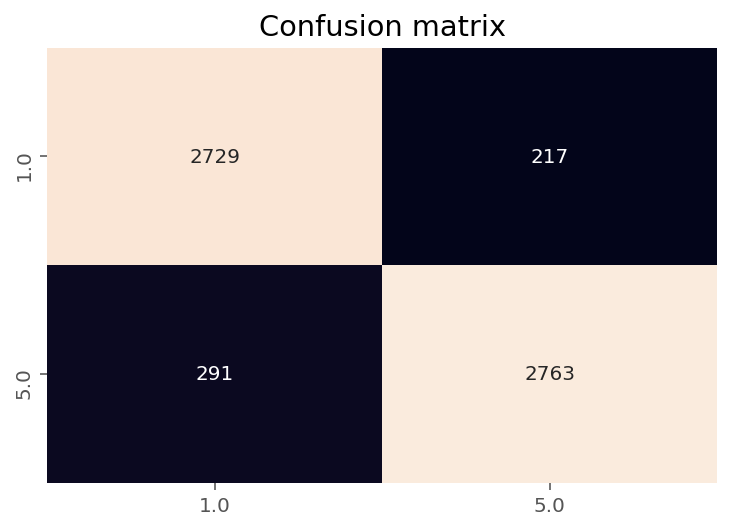

In [144]:
labels = grid_tf_idf_LDA.best_estimator_.classes_

sns.heatmap(
    data=confusion_matrix(y_test, predictions), 
    annot=True, 
    fmt="d", 
    cbar=False,
    xticklabels=labels,
    yticklabels=labels
)

plt.title("Confusion matrix")
plt.show()

### Итого:

In [151]:
models=['grid_cntv', 'grid_tf_idf', 'grid_tf_idf_TruncatedSVD', 'grid_tf_idf_LDA']

for model in models:
    print(model[5:])
    predictions=eval(model).best_estimator_.predict(X_test)
    print("f1_score: {0:6.3f}\nAccuracy: {0:6.3f}\n\n".format(
        f1_score(y_test, predictions, average='macro'), 
        accuracy_score(y_test, predictions)))

cntv
f1_score:  0.948
Accuracy:  0.948


tf_idf
f1_score:  0.952
Accuracy:  0.952


tf_idf_TruncatedSVD
f1_score:  0.940
Accuracy:  0.940


tf_idf_LDA
f1_score:  0.915
Accuracy:  0.915




**𝑡𝑓−𝑖𝑑𝑓 наиболее удачная модель**

In [ ]:
pass